<a href="https://colab.research.google.com/github/trilusa/SeniorDesign/blob/main/Algorithms/CNN/HRTF_Localizaiton_model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! pip install datasets[audio] yt-dlp

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, resample
import time

import tensorflow as tf
print(tf.__version__)

from IPython.display import Audio

from google.colab import data_table
data_table.enable_dataframe_formatter()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.15.0


# Synthesize Data For Training
Load in a bunch of wave files, use tf utilities to clip into 1 second intervals. At 32 kS/s there should be 32000 samples.


In [2]:
target_rate = 32000
window_L=1024
num_clips= 32

In [3]:
#download music clips
# https://huggingface.co/datasets/google/MusicCaps
# https://colab.research.google.com/github/nateraw/download-musiccaps-dataset/blob/main/download_musiccaps.ipynb
import subprocess
import os
from pathlib import Path

from datasets import load_dataset, Audio


def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'


def main(
    data_dir: str,
    sampling_rate: int = target_rate,
    limit: int = None,
    num_proc: int = 1,
    writer_batch_size: int = 100,
):
    """
    Download the clips within the MusicCaps dataset from YouTube.
    Args:
        data_dir: Directory to save the clips to.
        sampling_rate: Sampling rate of the audio clips.
        limit: Limit the number of examples to download.
        num_proc: Number of processes to use for downloading.
        writer_batch_size: Batch size for writing the dataset. This is per process.
    """

    ds = load_dataset('google/MusicCaps', split='train')
    if limit is not None:
        print(f"Limiting to {limit} examples")
        ds = ds.select(range(limit))

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True, parents=True)

    def process(example):
        outfile_path = str(data_dir / f"{example['ytid']}.wav")
        status = True
        if not os.path.exists(outfile_path):
            status = False
            status, log = download_clip(
                example['ytid'],
                outfile_path,
                example['start_s'],
                example['end_s'],
            )

        example['audio'] = outfile_path
        example['download_status'] = status
        return example

    return ds.map(
        process,
        num_proc=num_proc,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', Audio(sampling_rate=sampling_rate))

ds = main('./music_data', num_proc=8, limit=num_clips)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Limiting to 32 examples


In [4]:
print(type(ds))

<class 'datasets.arrow_dataset.Dataset'>


In [5]:
# ds.save_to_disk("/content/drive/My Drive/Senior Design/music/")
# pa.read_dataset("/content/drive/My Drive/Senior Design/music/music_dataset.parquet")

In [6]:
# print(ds[0]['audio']['array'])
audio = []
sample_rate = ds[0]['audio']['sampling_rate']
err_cnt = 0
problem_files = []
for i in range(len(ds)):
    try:
        audio.append(ds[i]['audio']['array'])
    except FileNotFoundError:
        err_cnt += 1
        problem_files.append(i)
        print(f"File at idx {i} not found")
    # print(f"\r{i}", end="")
print(len(audio))

32


In [7]:
def compute_spectrogram(data, fs, window_L=1024):
    frequencies, times, Sxx = spectrogram(data, fs=fs, window='hamming',
                                          nperseg=window_L, noverlap=window_L//2, nfft=window_L, scaling='density')
    return frequencies, times, Sxx[:,:1+window_L//2]

def resample_audio(audio_data, orig_fs, target_fs):
    if orig_fs != target_fs:
        # Calculate the number of samples after resampling
        num_samples = round(len(audio_data) * float(target_fs) / orig_fs)
        audio_data = resample(audio_data, num_samples)
    return audio_data

def compute_LRspectra(L, R, fs, target_fs=32000,window_L=1024):
    L = resample_audio(L/(2**15), fs, target_fs)
    R = resample_audio(R/(2**15), fs, target_fs)
    _, _, Sxx_L = compute_spectrogram(L, target_fs,window_L)
    _, _, Sxx_R = compute_spectrogram(R, target_fs,window_L)
    Sxx_L = 10*np.log10(np.mean(Sxx_L, axis=1))  # calc spectrum by average over time slices
    Sxx_R = 10*np.log10(np.mean(Sxx_R, axis=1))
    maxLR = np.max([np.max(Sxx_L), np.max(Sxx_R)])  # normalize so max of L and R together maps to 0db, preserves relative amplitude
    Sxx_L -= maxLR
    Sxx_R -= maxLR
    return Sxx_L, Sxx_R

def plot_spectrogram(spect):
    plt.imshow(spect,aspect=1)
    plt.colorbar()
    plt.show()

In [8]:
## Run once
# file_name = "/content/drive/My Drive/Senior Design/hrtf/raw_whitenoise/raw_whitenoise2_all.pkl"
# df_hrtf=pd.read_pickle(file_name)
# df_hrtf['HRTF_L'], df_hrtf['HRTF_R'] = zip(*df_hrtf.apply(lambda row: compute_LRspectra(row['L'], row['R'], fs=row['sample_rate'], window_L=window_L), axis=1))
# df_hrtf['sample_rate'] = target_rate
# df_hrtf.drop(['L','R'], axis=1, inplace=True)
# df_hrtf['az'] = df_hrtf['az'].apply(lambda x: x-100) #rotate coordinate so centered
# df_hrtf['el'] = df_hrtf['el'].apply(lambda x: x-100)
# df_hrtf.to_pickle("/content/drive/My Drive/Senior Design/hrtf/HRTF_df.pkl")

In [9]:
df_hrtf=pd.read_pickle("/content/drive/My Drive/Senior Design/hrtf/HRTF_df.pkl")
df_hrtf['HRTF_L'] = df_hrtf['HRTF_L'].apply(lambda x: x.astype(np.float32))
df_hrtf['HRTF_R'] = df_hrtf['HRTF_R'].apply(lambda x: x.astype(np.float32))
df_hrtf['az'] = df_hrtf['az'].apply(lambda x: np.float16(x))
df_hrtf['el'] = df_hrtf['el'].apply(lambda x: np.float16(x))
# df_hrtf.head()

In [10]:
target_rate = 32000
window_L=1024
raw_training_spectrograms = []
num_spec_per_example = 3
sample_per_slice = 1 * sample_rate
front_cuttoff_idx = 1*sample_per_slice

for a in audio:
    total_seconds = a.shape[0] // sample_rate  # total available full seconds

    for i in range(num_spec_per_example):
        idx = i * sample_per_slice
        seg = a[front_cuttoff_idx+idx : idx+sample_per_slice+front_cuttoff_idx]
        # seg /= (2**15) #normalize

        stft = tf.signal.stft(seg, frame_length=window_L, frame_step=window_L//2, fft_length=window_L)
        spec = 10*tf.math.log(tf.abs(stft),10)
        # power_spectrogram = tf.math.pow(spectrogram, 2)
        raw_training_spectrograms.append(tf.cast(spec,dtype=tf.float32))

    # training_examples.append(spectrograms)
print(len(raw_training_spectrograms))
print(raw_training_spectrograms[0].shape)
# plot_spectrogram(raw_training_spectrograms[0])
# raw_training_spectrograms_ds = tf.data.Dataset.from_tensor_slices(raw_training_spectrograms)
# tf.data.experimental.save(raw_training_spectrograms_ds, '/content/drive/My Drive/Senior Design/synth_data/')
# tensor_spec = raw_training_spectrograms_ds.element_spec
# print(tensor_spec)
del(audio)

96
(61, 513)


In [11]:
num_spectrograms = len(raw_training_spectrograms)
num_hrtfs = len(df_hrtf['HRTF_L'].values)
total_examples = num_spectrograms * num_hrtfs
print(f"{total_examples/1e6} Million Examples Prepared")

0.450432 Million Examples Prepared


In [12]:
#finally works!!!
HRTF_L_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['HRTF_L'].values.tolist())
HRTF_R_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['HRTF_R'].values.tolist())
az_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['az'].values.tolist())
el_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['el'].values.tolist())

HRTF_dataset = tf.data.Dataset.zip( (HRTF_L_dataset, HRTF_R_dataset, az_dataset, el_dataset))
spectrogram_dataset = tf.data.Dataset.from_tensor_slices(raw_training_spectrograms)

def cartesian_product(HRTF_L, HRTF_R, az, el):
    return spectrogram_dataset.map(lambda s: (HRTF_L, HRTF_R, az, el, s))

def process_elements(HRTF_L, HRTF_R, az, el, spec ):
    # HRTF_L, HRTF_R, az, el, spec = all_examples_ds_tuple
    HRTF_stacked = tf.stack([HRTF_L, HRTF_R], axis=1)  # Shape: (513, 2)
    spectrogram_stacked = tf.stack([spec, spec], axis=2)  # Duplicate spectrogram across a new dimension
    input_tensor = spectrogram_stacked + HRTF_stacked
    target_tensor = [az, el]
    return input_tensor, target_tensor

all_examples_ds = HRTF_dataset.flat_map(cartesian_product)
all_examples_ds = all_examples_ds.map(process_elements)

# all_examples_ds.to_pickle('/content/drive/My Drive/Senior Design/synth_data/all_examples_ds.pkl')


In [13]:
epochs=50
dropout=.5
learning_rate = 0.01
num_training_examples = int(150000)
all_examples_ds = all_examples_ds.shuffle(buffer_size=50000)
all_examples_ds_subsample =  all_examples_ds.take(num_training_examples)
batch_size = 256
train_size = int(num_training_examples * .8)
print(train_size)

train_dataset = all_examples_ds_subsample.take(train_size)
validation_dataset = all_examples_ds_subsample.skip(train_size)

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


120000


#Model Training




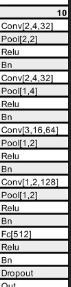

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout


model = Sequential([
    # assume  input shape  (61, 513, 2)
    Conv2D(filters=32, kernel_size=(2, 4), padding='same', activation='relu', input_shape=(61, 513, 2)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(2, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 4)),

    Conv2D(filters=64, kernel_size=(3, 16), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(filters=128, kernel_size=(1, 2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 2)),

    Flatten(),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(rate=dropout),

    Dense(units=2, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer=optimizer, loss='MSE', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 513, 32)       544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 256, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30, 256, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 256, 32)       8224      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 256, 32)       128       
 chNormalization)                                                
                                                        

In [15]:
# import gc
# tf.keras.backend.clear_session()
# class GC_Callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     gc.collect()

In [16]:
from datetime import datetime
now_str = datetime.now().strftime("%Y%m%d-%H%M%S")
folder_path = f"/content/drive/My Drive/Senior Design/models/{now_str}"
os.makedirs(folder_path, exist_ok=True)
keras_file_path = f"{folder_path}/hrtf_localization_model_{now_str}.keras"

class Model_Save_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model.save(keras_file_path)

In [17]:
meta_string=f"""{num_clips} Audio Clips, sample_rate={sample_rate}, spectrogam window len = {window_L}
{num_spec_per_example} spectrograms per music clip ({sample_per_slice} each @ {sample_rate/1000}khz)
Training set = {int(0.8*num_training_examples)} examples (synthesized data)
Validation set = {int(0.2*num_training_examples)}examples (synthesized data)
Batch size = {batch_size}, learning rate = {learning_rate}
dropout rate = {dropout}\n planned epochs = {epochs}"""

with open(f"{folder_path}/metadata{now_str}.txt", 'w') as file:
    file.write(meta_string)

In [18]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(f"{folder_path}/training_history.csv")
# log_dir = f"{folder_path}/logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
t0=time.time()

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[Model_Save_Callback(), csv_logger]
)
total_time = time.time()-t0
total_time_str = f"Total training time:  {datetime.fromtimestamp(total_time).strftime("%H:%M:%S")}"
print(total_time_str)

Epoch 1/50
      6/Unknown - 22s 183ms/step - loss: 403.1756 - mae: 14.2728

469/469 [==============================] - 141s 255ms/step - loss: 42.6600 - mae: 4.5476 - val_loss: 51.8068 - val_mae: 6.0510
Epoch 2/50
469/469 [==============================] - 121s 244ms/step - loss: 48.3202 - mae: 4.8041 - val_loss: 56.7877 - val_mae: 6.1110
Epoch 3/50
469/469 [==============================] - 120s 244ms/step - loss: 45.8022 - mae: 4.6039 - val_loss: 34.1379 - val_mae: 4.5406
Epoch 4/50
469/469 [==============================] - 119s 242ms/step - loss: 46.5665 - mae: 4.5462 - val_loss: 42.0950 - val_mae: 5.1577
Epoch 5/50
 33/469 [=>............................] - ETA: 1:19 - loss: 280.8752 - mae: 9.3562

In [ ]:
with open(f"{folder_path}/metadata{now_str}.txt", 'a') as file:
    file.write("\n"+total_time_str)

#save model manually
# folder_path = f"/content/drive/My Drive/Senior Design/models/{now_str}"
# os.makedirs(folder_path, exist_ok=True)
# file_path = f"{folder_path}/hrtf_localization_model_{now_str}.keras"
# model.save(file_path)

#load model manually
# from keras.models import load_model
# model = load_model(keras_file_path)


In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
mse= history.history['loss']
val_mse=history.history['val_loss']

mae= history.history['mae']
val_mae=history.history['val_mae']
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(2,1,1)


plt.title(meta_string)

plt.plot(mse[:],label="training")
plt.plot(val_mse,label="validation")
plt.ylabel("MSE")
plt.legend()
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.grid(True)
# plt.ylim((0,1000))


ax=plt.subplot(2,1,2)
# plt.plot([0,10],[1/407,1/407], label="random")
plt.plot(mae[:],label="training")
plt.plot(val_mae,label="validation")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.tight_layout()
plt.legend()
ax.set_yscale('log')
plt.grid(True)

fig.savefig(f"{folder_path}/training_history.png")
#min mse val = 4.6734

In [ ]:
#manual validation
val_prediction = model.predict(validation_dataset, verbose=1)
train_prediction = model.predict(train_dataset, verbose=1)

In [ ]:
val_targets = []
for inputs, targets in validation_dataset:
  val_targets.append(targets.numpy())
val_targets = np.concatenate(val_targets)

train_targets = []
for inputs, targets in train_dataset:
  train_targets.append(targets.numpy())
train_targets = np.concatenate(train_targets)

In [ ]:
val_err = val_targets - val_prediction
train_err = train_targets - train_prediction


val_target_az = val_targets[:,0]
val_target_el = val_targets[:,1]
val_result_az = val_prediction[:,0]
val_result_el = val_prediction[:,1]

val_err_az = val_err[:,0]
val_err_el = val_err[:,1]

train_target_az = train_targets[:,0]
train_target_el = train_targets[:,1]
train_result_az = train_prediction[:,0]
train_result_el = train_prediction[:,1]

train_err_az = train_err[:,0]
train_err_el = train_err[:,1]

print(f"Val Err: {val_err}")
print(f"Train Err {train_err}")



In [ ]:
df = pd.DataFrame(val_target_az, val_target_el, val_result_az, val_result_el, train_target_az, train_target_el, train_result_az, train_result_el,
        columns=['val_target_az', 'val_target_el', 'val_result_az','val_result_el', 'train_target_az','train_target_el', 'train_result_az', 'train_result_el'])
df.to_csv(f"{folder_path}/training_results.csv")


In [ ]:


# Scatter plot
fig=plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
plt.subplot(1,2,1)
plt.scatter(val_err_az, val_err_el, label='Validation', alpha=0.5)
plt.title("Azimuth and Elevation Error on Validation Set")
plt.xlabel("Azimuth (degrees)")
plt.ylabel("Elevation (degrees)")

mean_val_err_az, mean_val_err_el = np.mean(val_err_az), np.mean(val_err_el)
plt.scatter(mean_val_err_az, mean_val_err_el, color='red', s=25, edgecolors='black', zorder=5)

plt.boxplot(val_err_az, vert=False, positions=[mean_val_err_el], widths=2, manage_ticks=False)  # Horizontal boxplot for x
plt.boxplot(val_err_el, positions=[mean_val_err_az], widths=2, manage_ticks=False)  # Vertical boxplot for y

# Annotating the mean point
plt.annotate('Mean: ({:.2f}, {:.2f})'.format(mean_val_err_az, mean_val_err_el),
             (mean_val_err_az, mean_val_err_el),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')
# plt.xlim((-100,100))
# plt.ylim((-100,100))
plt.grid(True)
# plt.axis('square')


plt.subplot(1,2,2)
plt.scatter(train_err_az, train_err_el, label='Training', alpha=0.5)
plt.title("Azimuth and Elevation Error on Traing Set")
plt.xlabel("Azimuth (degrees)")
plt.ylabel("Elevation (degrees)")

mean_train_err_az, mean_train_err_el = np.mean(train_err_az), np.mean(train_err_el)
plt.scatter(mean_train_err_az, mean_train_err_el, color='red', s=25, edgecolors='black', zorder=5)

plt.boxplot(train_err_az, vert=False, positions=[mean_train_err_el], widths=2, manage_ticks=False)  # Horizontal boxplot for x
plt.boxplot(train_err_el, positions=[mean_train_err_az], widths=2, manage_ticks=False)  # Vertical boxplot for y

# Annotating the mean point
plt.annotate('Mean: ({:.2f}, {:.2f})'.format(mean_train_err_az, mean_train_err_el),
             (mean_train_err_az, mean_train_err_el),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')
# plt.xlim((-100,100))
# plt.ylim((-100,100))
plt.grid(True)
# plt.axis('square')

plt.tight_layout()
plt.show()
fig.savefig(f"{folder_path}/azimuth_elevation_error.png")


In [ ]:
bins=21
print(val_target_az)
fig=plt.figure()
plt.hist(val_result_az,label="predicted",bins=bins)
plt.hist(val_target_az,label="truth",bins=bins)
plt.legend()
plt.title("Distribution of Azimuths in Predicted and GT (Validation set)")
fig.savefig(f"{folder_path}/validation_azimuth_distribution.png")

In [ ]:
fig=plt.figure()

plt.hist(val_result_el,label="predicted",bins=bins)
plt.hist(val_target_el,label="truth",bins=bins)
plt.legend()
plt.title("Distribution of Elevations in Predicted and GT (Validation Set)")
fig.savefig(f"{folder_path}/validation_elevation_distribution.png")

In [ ]:
fig=plt.figure()
plt.hist(train_result_az,label="predicted",bins=bins)
plt.hist(train_target_az,label="truth",bins=bins)
plt.legend()
plt.title("Distribution of Azimuths in Predicted and GT (Training Set)")
fig.savefig(f"{folder_path}/training_azimuth_distribution.png")

In [ ]:
fig=plt.figure()
plt.hist(train_result_el,label="predicted",bins=bins)
plt.hist(train_target_el,label="truth",bins=bins)
plt.legend()
plt.title("Distribution of Elevations in Predicted and GT (Training Set)")
fig.savefig(f"{folder_path}/training_elevation_distribution.png")

In [ ]:
#azimuth val
fig=plt.figure()
plt.scatter(val_target_az,val_result_az,label="az")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Azimuth")
plt.ylabel("Predicted Azimuth")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Azimuth accuracy for Validation Set")
plt.grid(True)
fig.savefig(f"{folder_path}/val_azimuth_diagonal.png")

In [ ]:
#elevation
fig=plt.figure()
plt.scatter(val_target_el,val_result_el,label="el")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Elevation")
plt.ylabel("Predicted Elevation")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Elevation Accuracy for Validation set")
plt.grid(True)
fig.savefig(f"{folder_path}/val_elevation_diagonal.png")

In [ ]:
#azimuth train
fig=plt.figure()
plt.scatter(train_target_az,train_result_az,label="az")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Azimuth")
plt.ylabel("Predicted Azimuth")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Azimuth accuracy for Training Set")
plt.grid(True)
fig.savefig(f"{folder_path}/training_azimuth_diagonal.png")

In [ ]:
#elevation train
fig=plt.figure()
plt.scatter(train_target_el,train_result_el,label="el")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Elevation")
plt.ylabel("Predicted Elevation")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Elevation Accuracy for Training set")
plt.grid(True)
fig.savefig(f"{folder_path}/training_elevation_diagonal.png")

In [ ]:
# df1 = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings1.pkl")
# df2 = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings2.pkl")
# df3 = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings3.pkl")
# df = [df1,df2,df3]
# df = pd.concat(df)
# df.to_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings_all.pkl")
# del df1,df2,df3
# df = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings_all.pkl")

In [ ]:
# targets = tf.convert_to_tensor(df['az','el'])
# targets = d/f.pop(columns=['az','el'])

# df_hrtf['HRTF_L'], df_hrtf['HRTF_R'] = zip(*df_hrtf.apply(lambda row: compute_LRspectrograms(row['L'], row['R'], fs=row['sample_rate'], window_L=window_L), axis=1))
#